In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'VSAT'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-01-01,333,-243,90,-6,41,283,126,519,83,...,1929,112,0,2,270,670,997,32,-96,45.74
1,2014-04-01,344,-251,93,-4,58,272,120,531,84,...,1960,99,0,2,276,690,1019,70,-74,45.74
2,2014-07-01,320,-238,82,-6,58,279,129,541,118,...,2056,86,0,2,252,789,1094,47,-98,48.28
3,2014-10-01,359,-242,117,24,42,280,127,526,118,...,2015,74,0,1,245,724,1018,112,-64,48.28
4,2015-01-01,340,-234,106,15,98,268,129,577,117,...,2153,82,0,1,269,819,1134,113,-149,48.28


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,76.91,651,-483,168,-45,182,369,261,...,502,6802,300,0,41,851,2899,4213,90,-296
37,2023-03-31,2023-04-21,76.91,666,-492,174,-59,1349,420,269,...,497,7730,272,0,38,957,2422,3906,50,-314
38,2023-06-30,2023-07-21,124.05,780,-545,235,-78,1959,631,336,...,2847,17898,378,0,60,1472,7218,11958,104,-375
39,2023-09-30,2023-10-21,124.53,1225,-766,459,-765,1962,664,346,...,3074,17072,389,0,63,1550,7228,11882,219,-366
40,2023-12-31,2024-02-11,125.32,1129,-767,361,-122,1571,676,354,...,3112,16651,315,0,63,1377,7223,11548,134,-421


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,76.91,651,-483,168,-45,182,369,261,...,6802,300,0,41,851,2899,4213,90,-296,1
37,2023-03-31,2023-04-21,76.91,666,-492,174,-59,1349,420,269,...,7730,272,0,38,957,2422,3906,50,-314,1
38,2023-06-30,2023-07-21,124.05,780,-545,235,-78,1959,631,336,...,17898,378,0,60,1472,7218,11958,104,-375,1
39,2023-09-30,2023-10-21,124.53,1225,-766,459,-765,1962,664,346,...,17072,389,0,63,1550,7228,11882,219,-366,1
40,2023-12-31,2024-02-11,125.32,1129,-767,361,-122,1571,676,354,...,16651,315,0,63,1377,7223,11548,134,-421,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,76.91,651.0,-483.0,168.0,-45.0,182.0,369.0,261.0,...,6802.0,300.0,0.0,41.0,851.0,2899.0,4213.0,90.0,-296.0,1
37,2023-03-31,2023-04-21,76.91,666.0,-492.0,174.0,-59.0,1349.0,420.0,269.0,...,7730.0,272.0,0.0,38.0,957.0,2422.0,3906.0,50.0,-314.0,1
38,2023-06-30,2023-07-21,124.05,780.0,-545.0,235.0,-78.0,1959.0,631.0,336.0,...,17898.0,378.0,0.0,60.0,1472.0,7218.0,11958.0,104.0,-375.0,1
39,2023-09-30,2023-10-21,124.53,1225.0,-766.0,459.0,-765.0,1962.0,664.0,346.0,...,17072.0,389.0,0.0,63.0,1550.0,7228.0,11882.0,219.0,-366.0,1
40,2023-12-31,2024-02-11,125.32,1129.0,-767.0,361.0,-122.0,1571.0,676.0,354.0,...,16651.0,315.0,0.0,63.0,1377.0,7223.0,11548.0,134.0,-421.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-01-22,61.650002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,0.483152,0.516848,4.706714,8.678571,32.487805,7.714286,0.27027,-0.018018,-0.012442,-0.025751
1,2014-01-29,57.990002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,0.483152,0.516848,4.706714,8.678571,32.487805,7.714286,0.27027,-0.018018,-0.012442,-0.025751
2,2014-02-05,60.029999,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,0.483152,0.516848,4.706714,8.678571,32.487805,7.714286,0.27027,-0.018018,-0.012442,-0.025751
3,2014-02-12,63.540001,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,0.483152,0.516848,4.706714,8.678571,32.487805,7.714286,0.27027,-0.018018,-0.012442,-0.025751
4,2014-02-19,66.760002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,0.483152,0.516848,4.706714,8.678571,32.487805,7.714286,0.27027,-0.018018,-0.012442,-0.025751


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-01-22,61.650002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,7.714286,0.27027,-0.018018,-0.012442,-0.025751,-117.494628,3.025613,2.117020,2.834738,5.507561
1,2014-01-29,57.990002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,7.714286,0.27027,-0.018018,-0.012442,-0.025751,-110.519278,2.845990,1.991338,2.709056,5.180591
2,2014-02-05,60.029999,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,7.714286,0.27027,-0.018018,-0.012442,-0.025751,-114.407173,2.946107,2.061390,2.779108,5.362836
3,2014-02-12,63.540001,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,7.714286,0.27027,-0.018018,-0.012442,-0.025751,-121.096652,3.118369,2.181922,2.899639,5.676406
4,2014-02-19,66.760002,2014-01-01,333.0,-0.524705,20.376038,45.74,512.0,11.193704,41.0,...,7.714286,0.27027,-0.018018,-0.012442,-0.025751,-127.233437,3.276398,2.292494,3.010212,5.964067


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

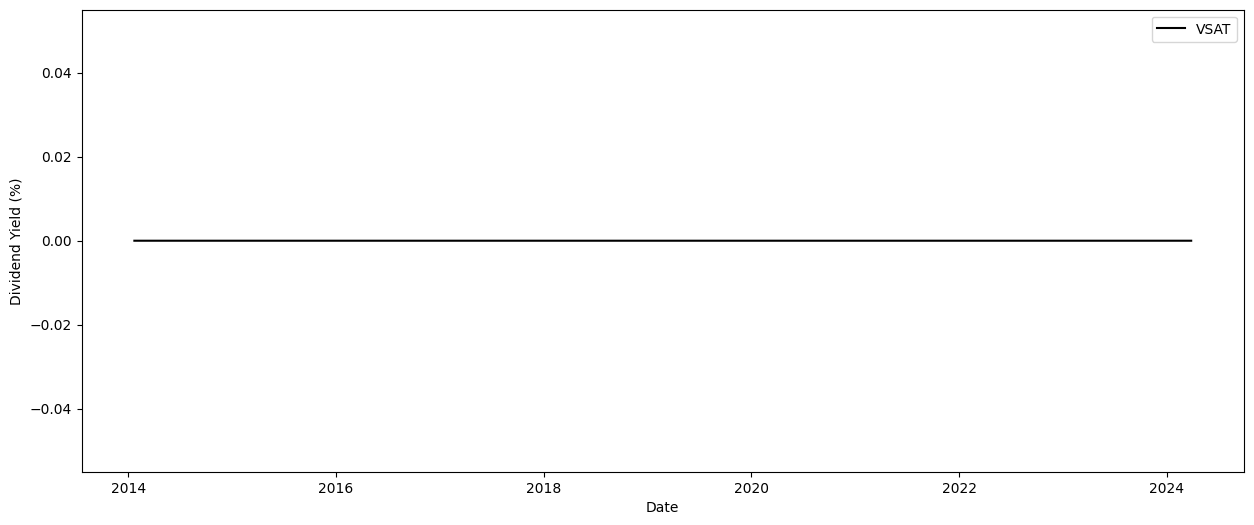

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


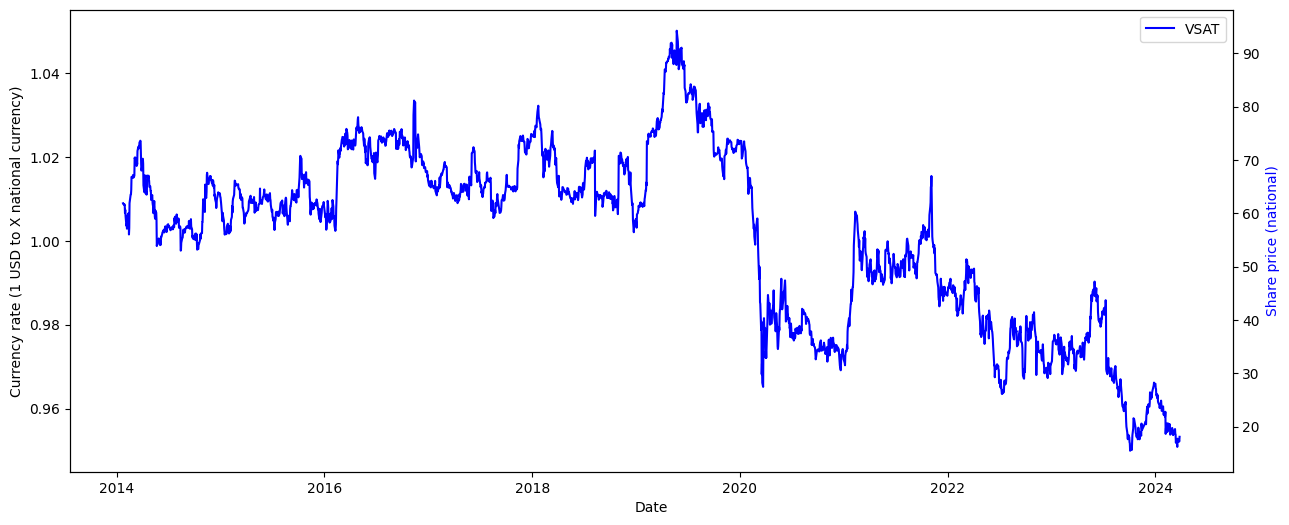

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

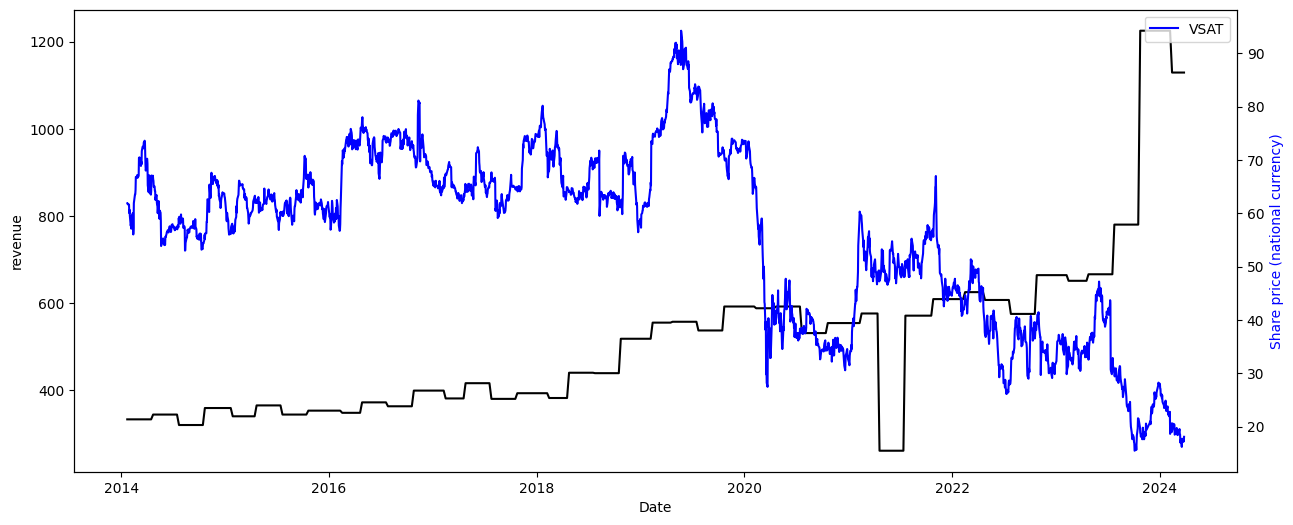

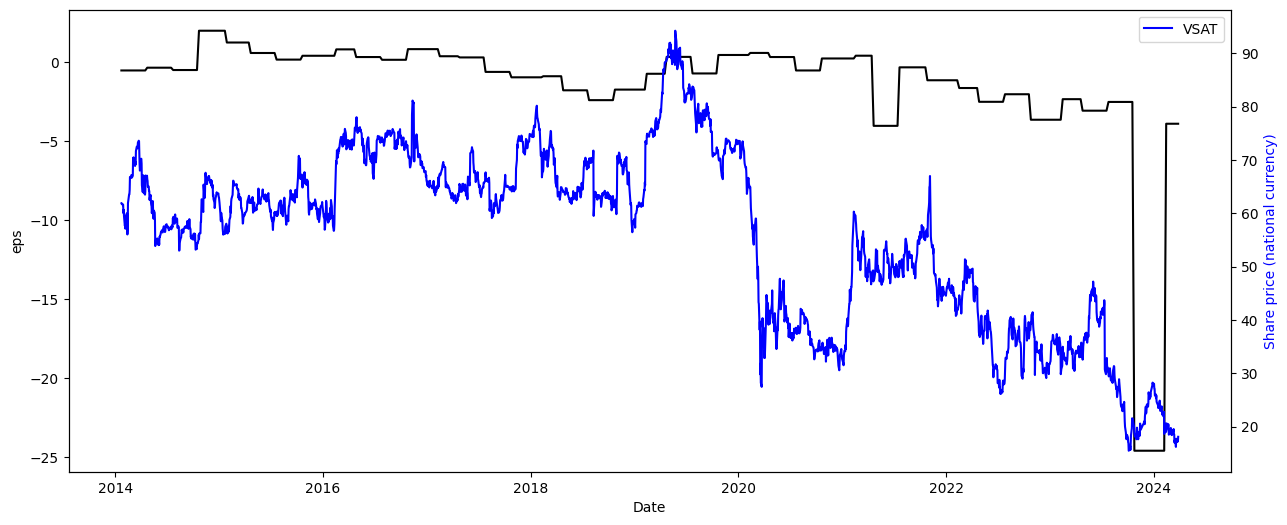

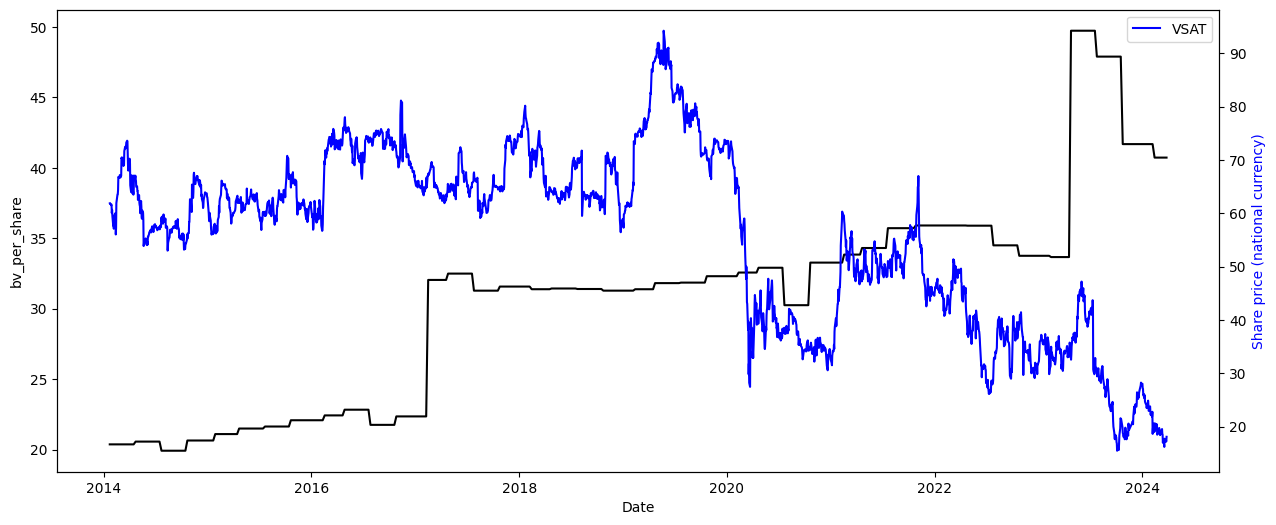

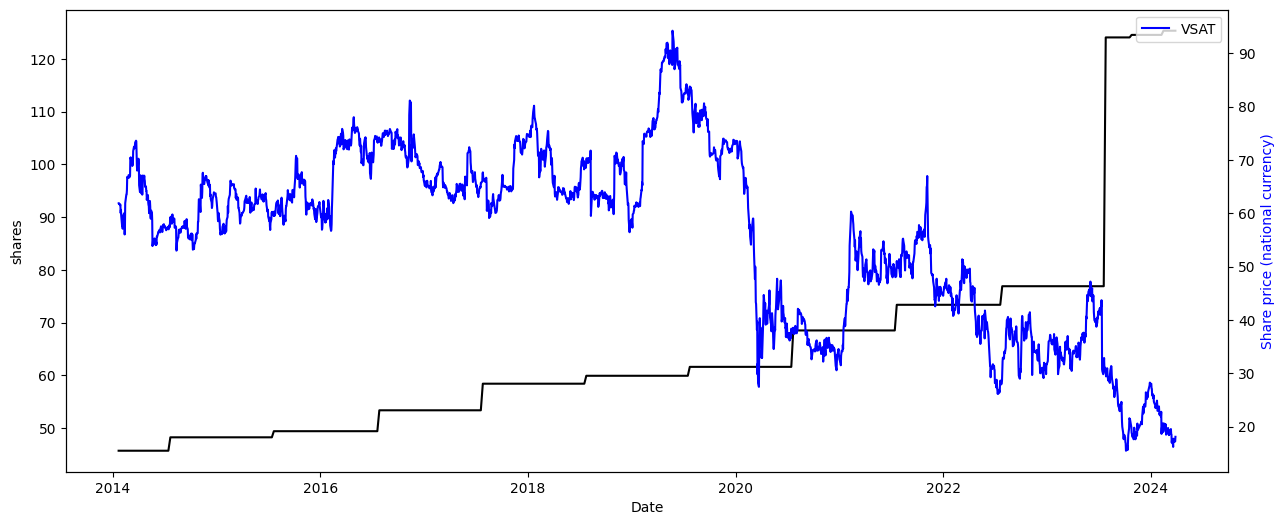

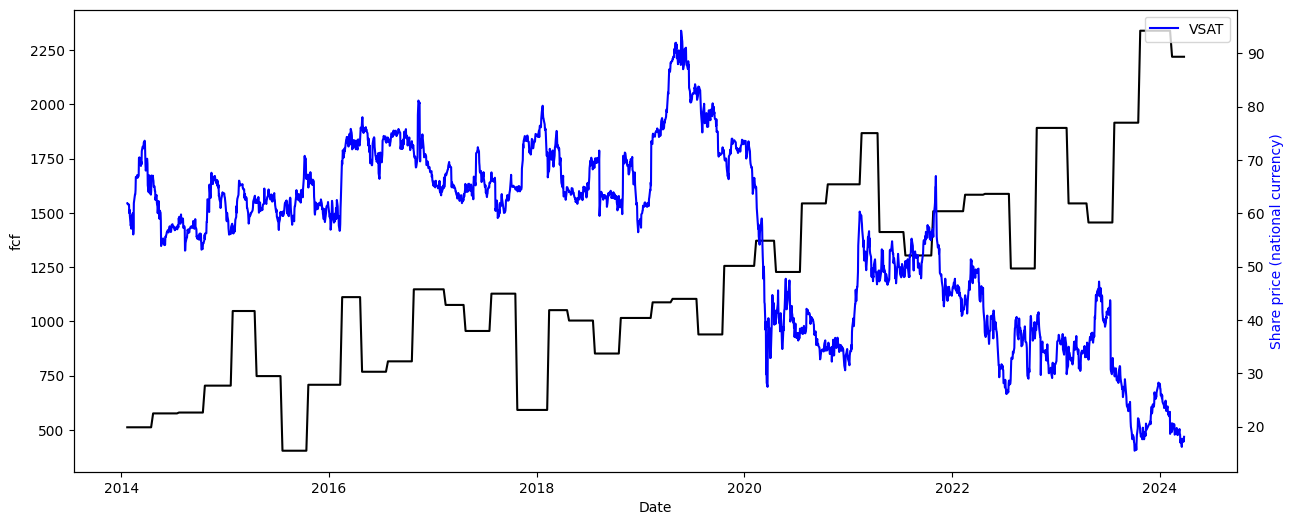

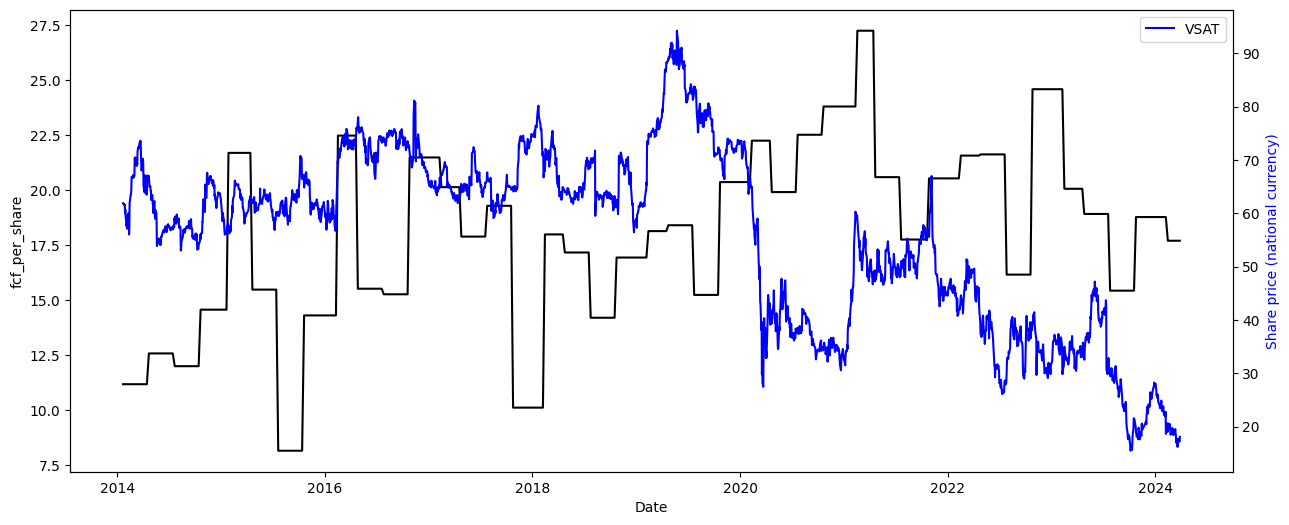

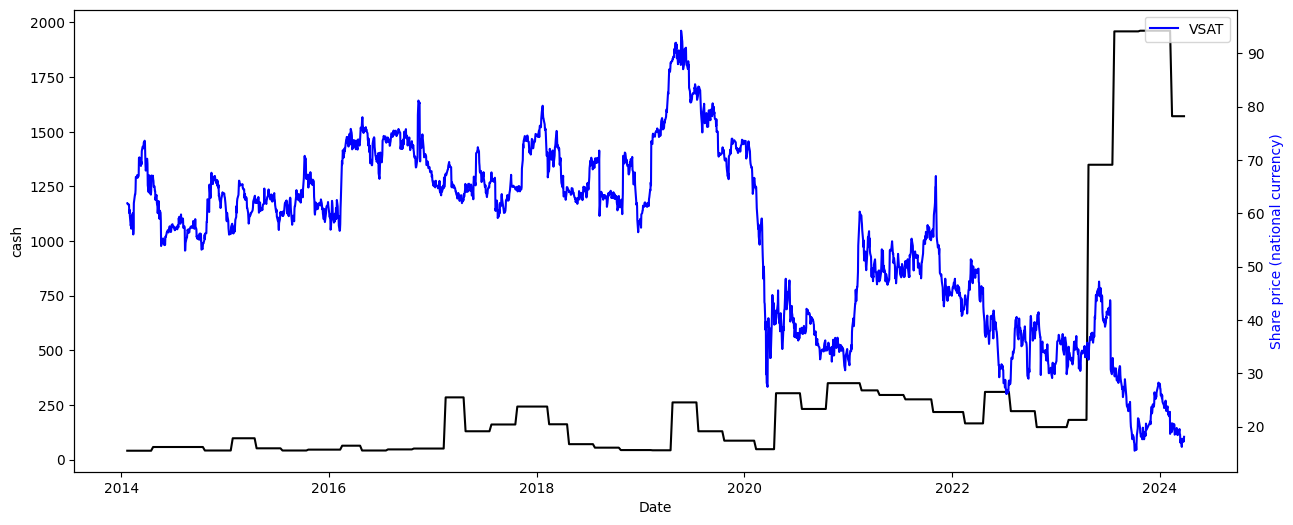

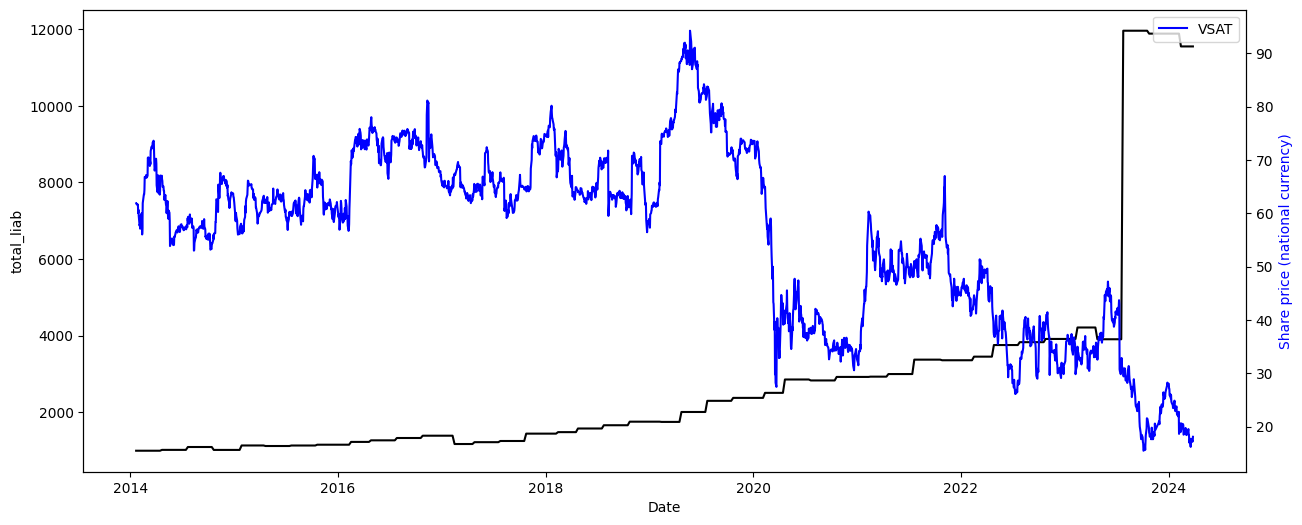

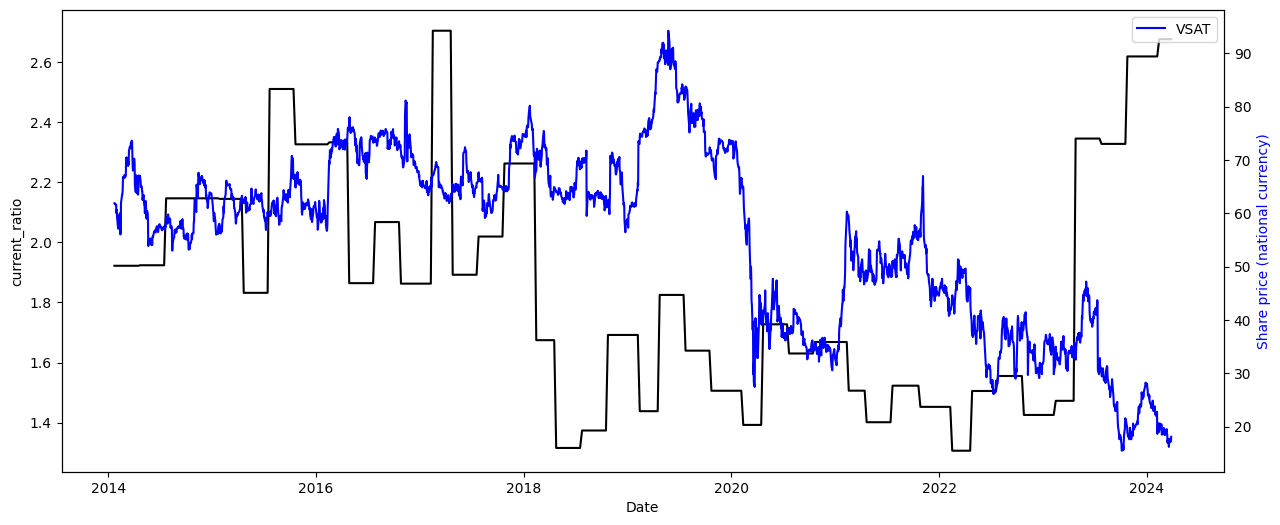

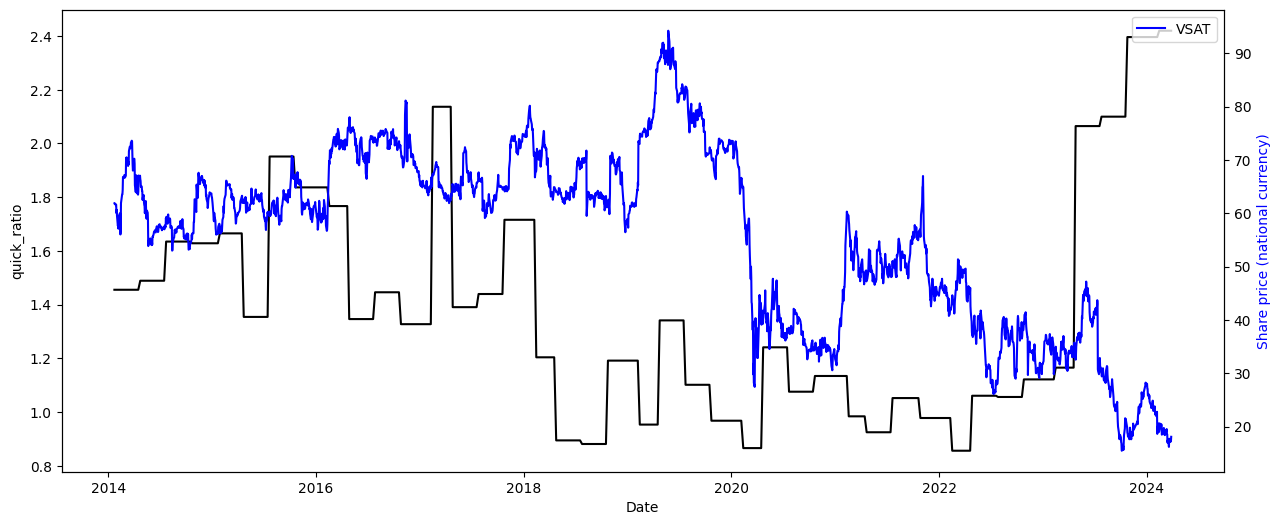

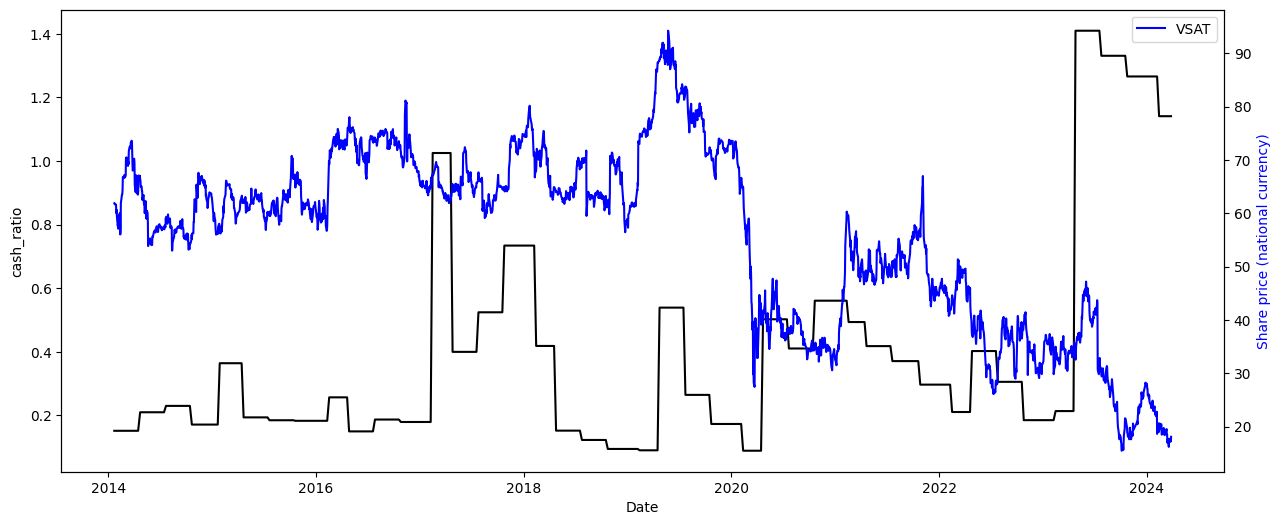

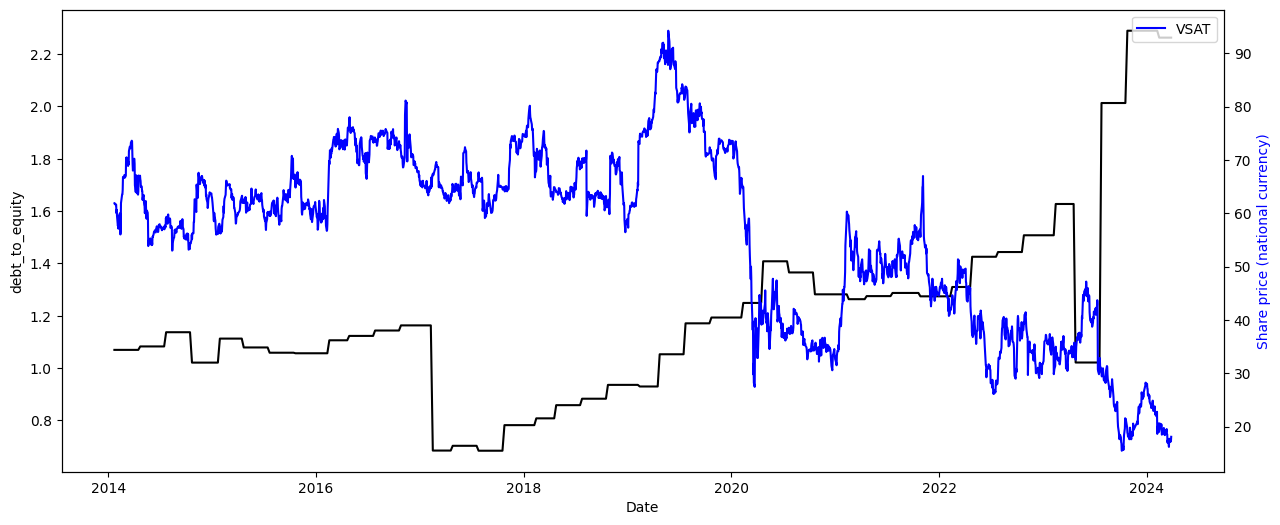

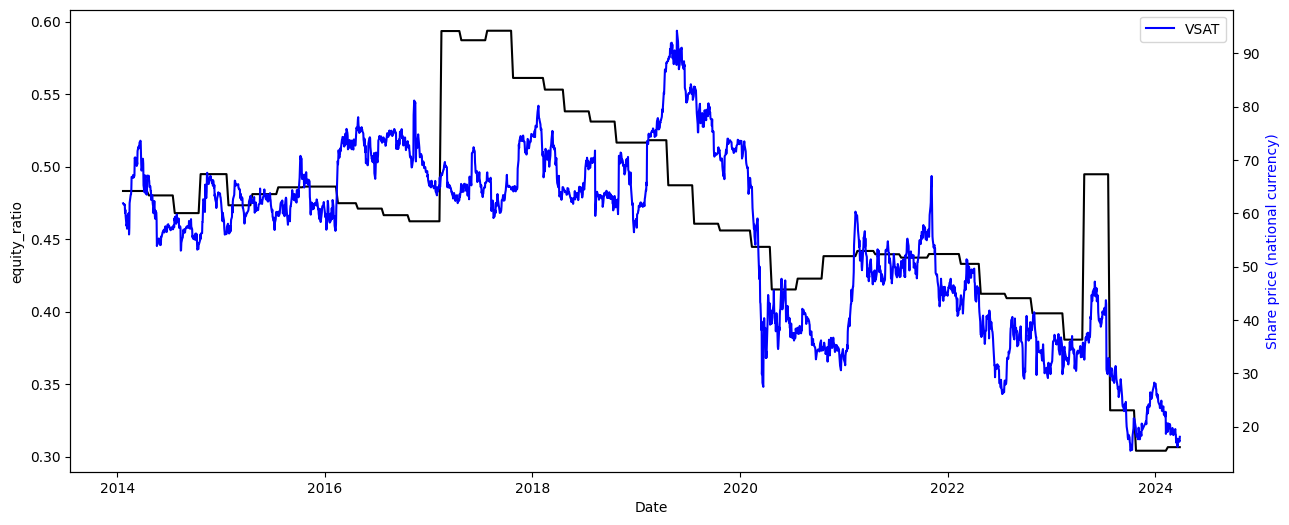

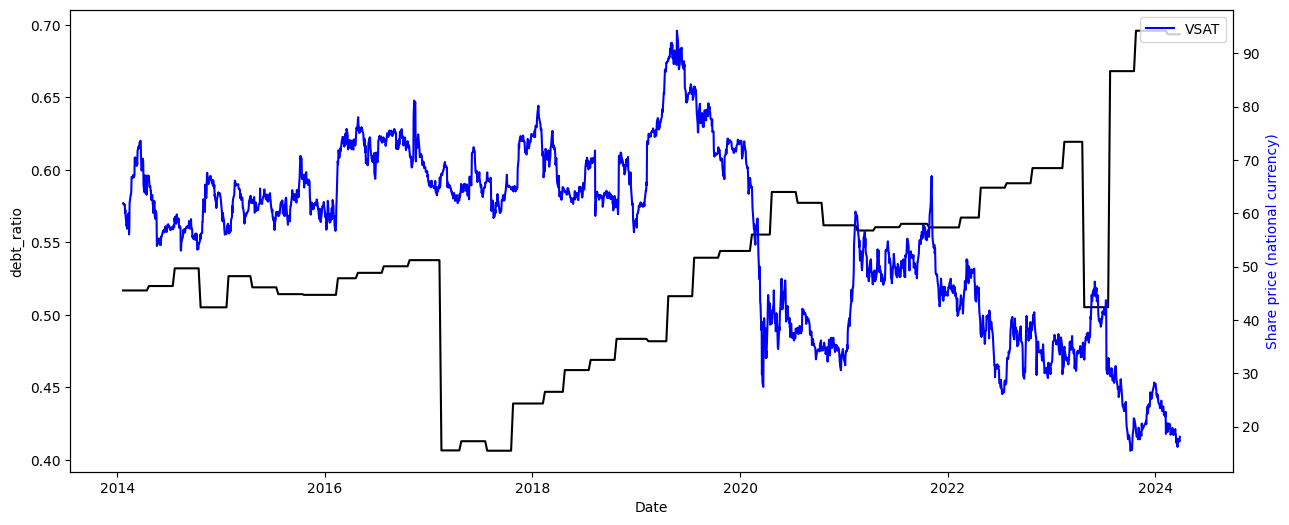

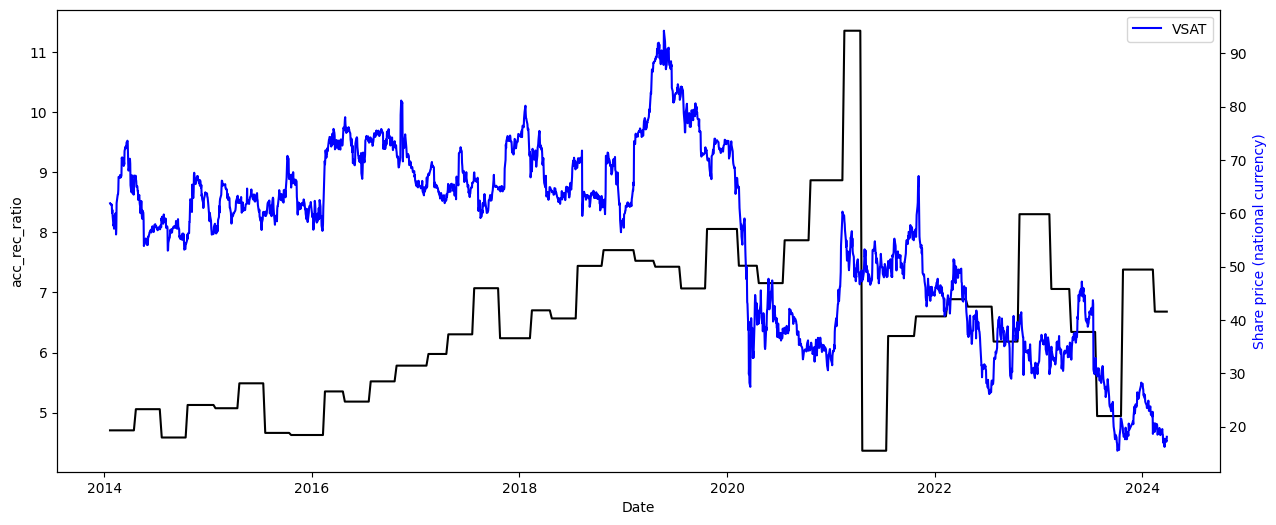

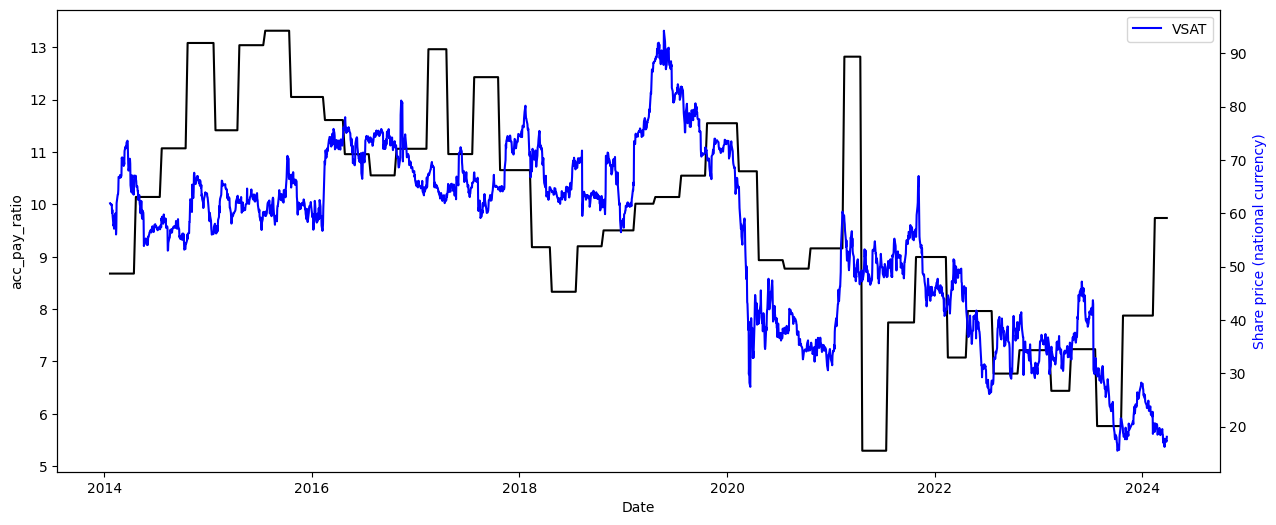

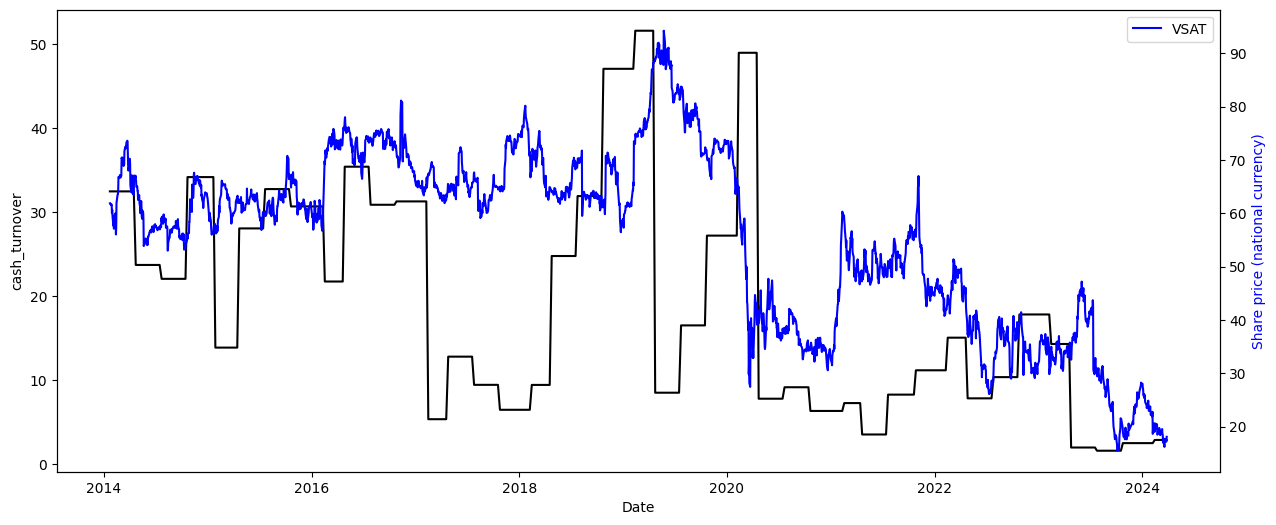

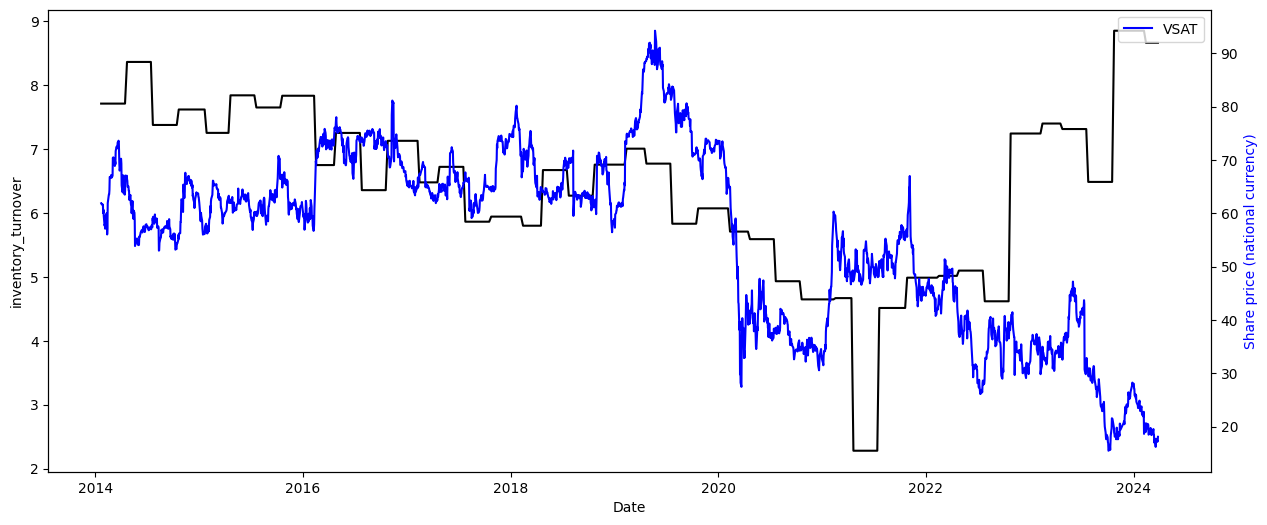

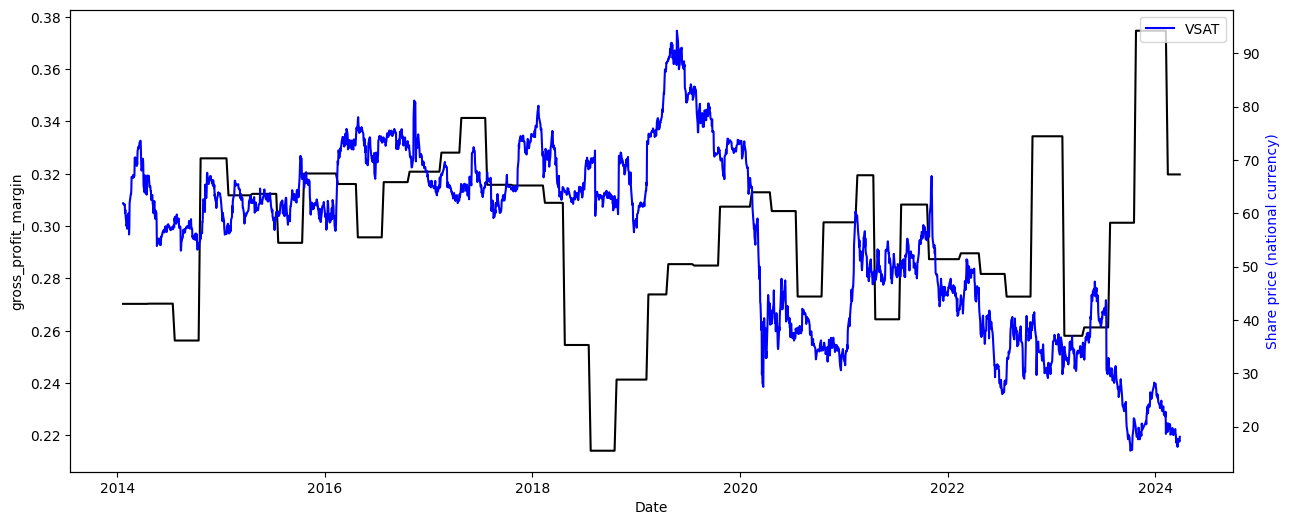

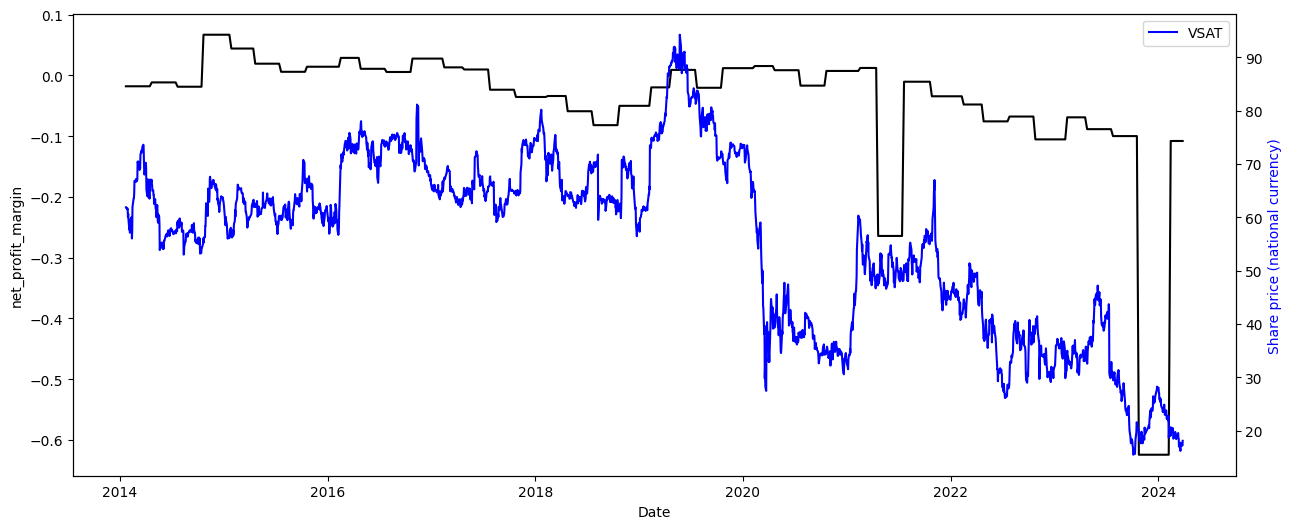

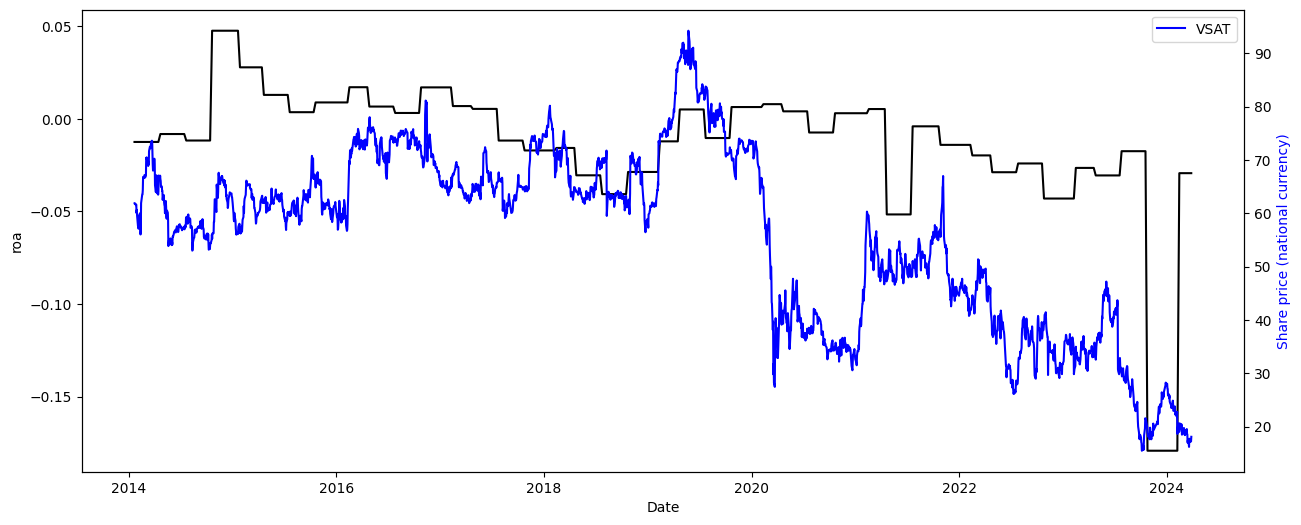

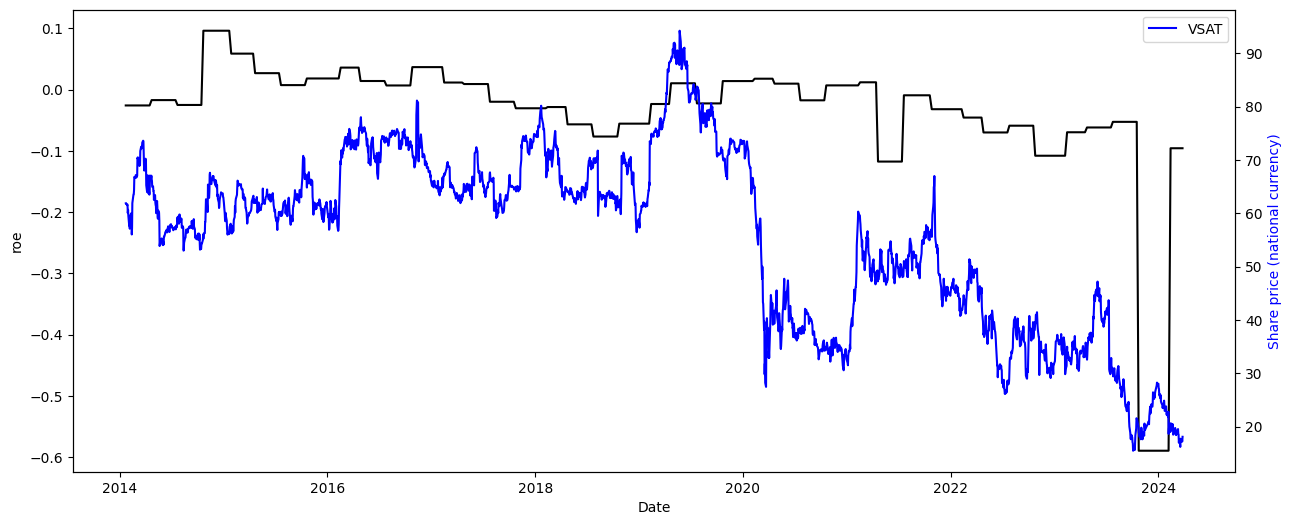

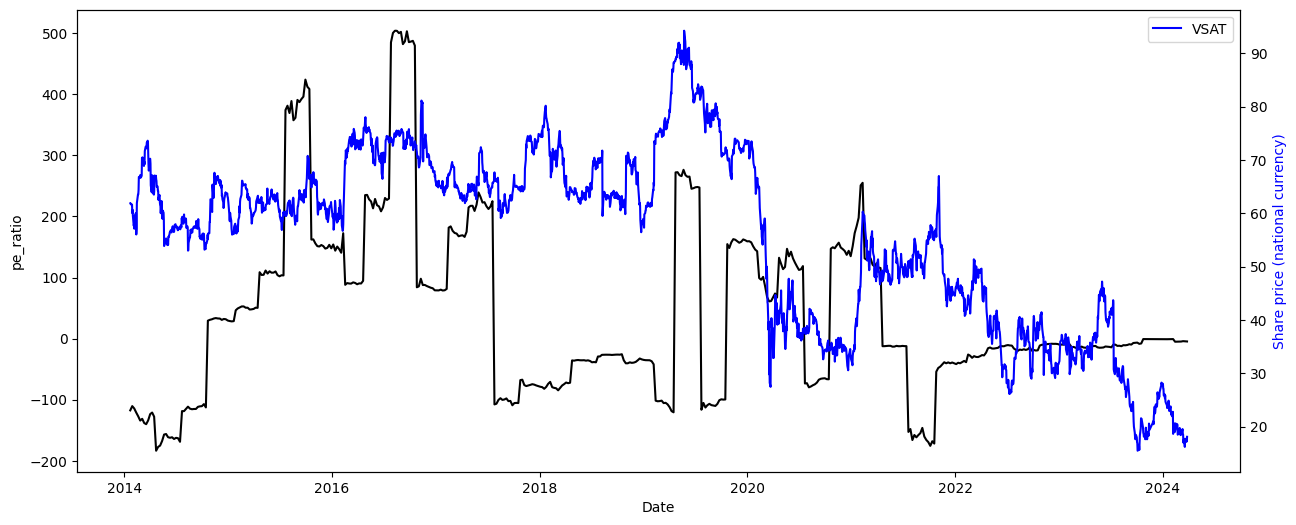

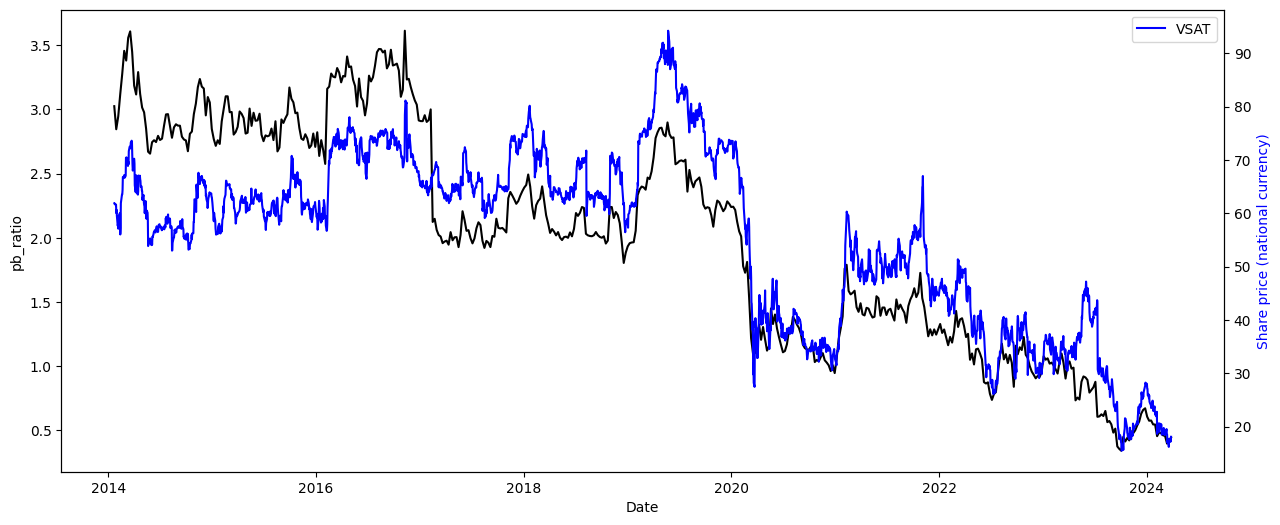

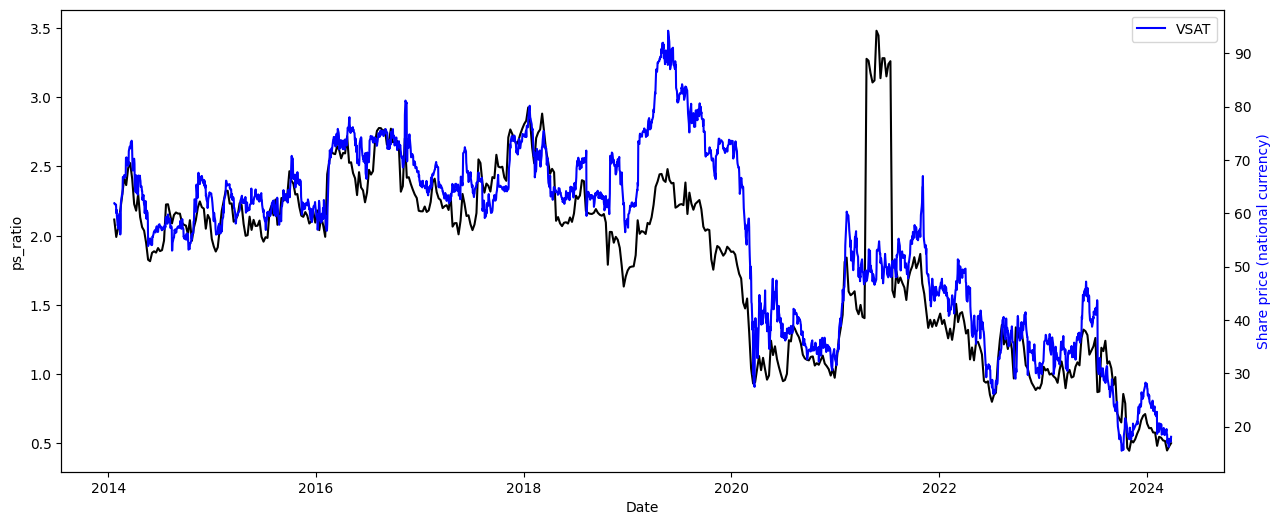

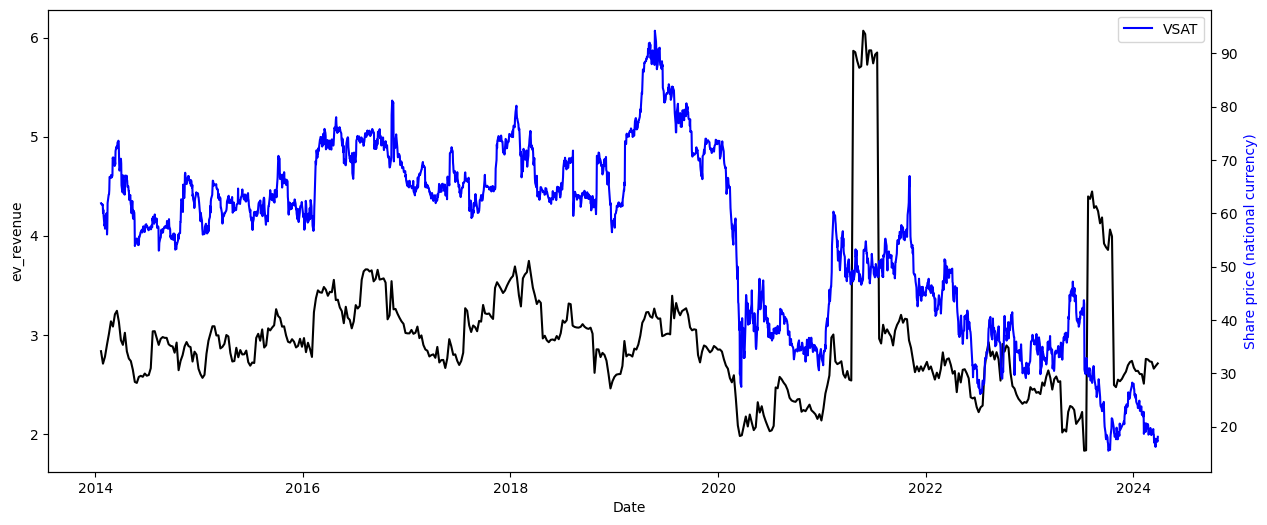

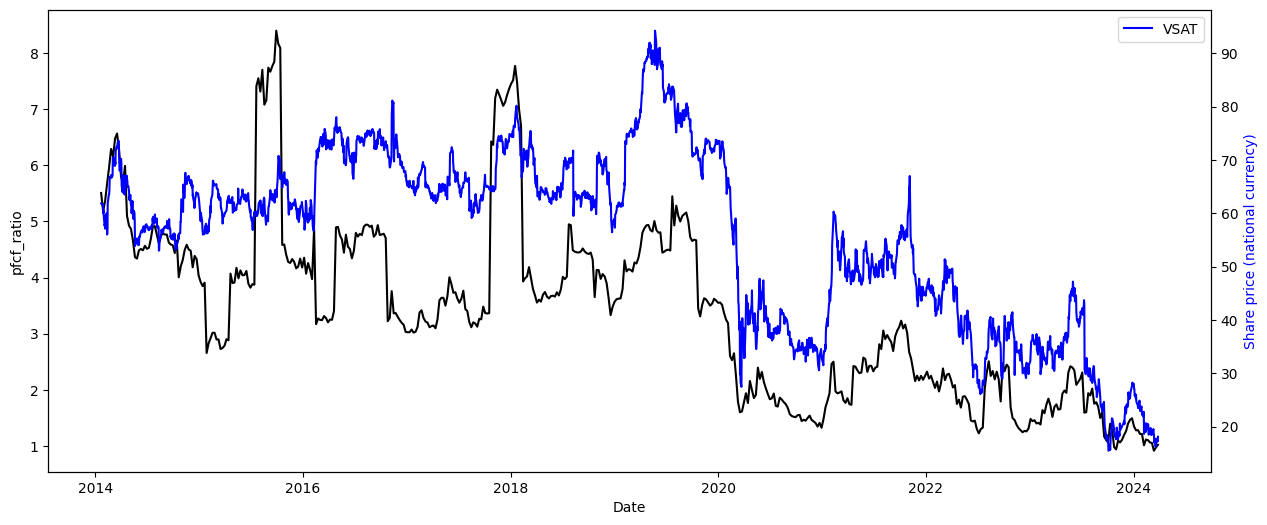

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

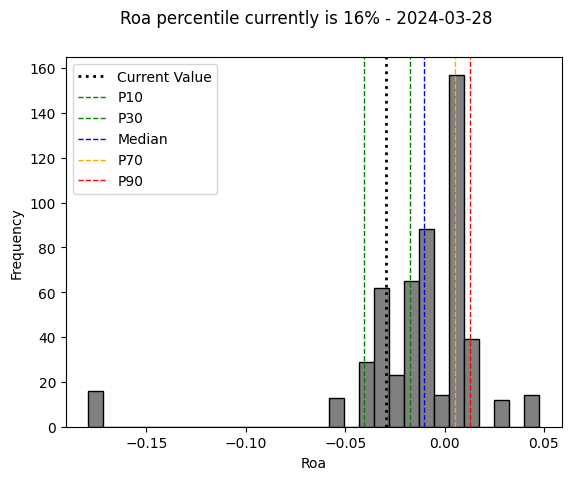

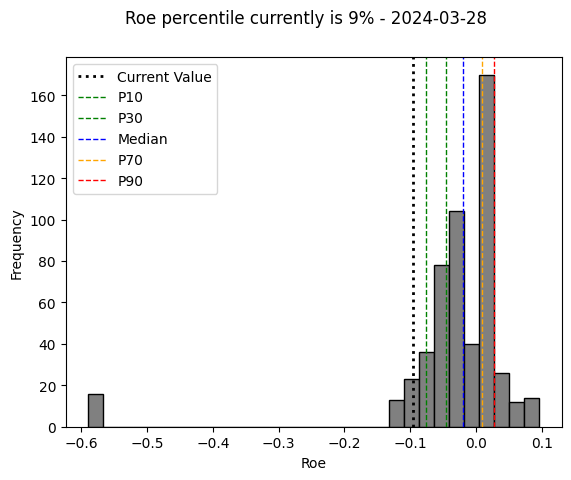

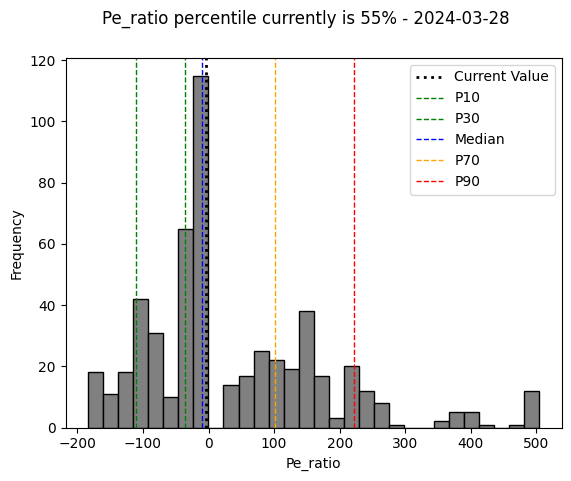

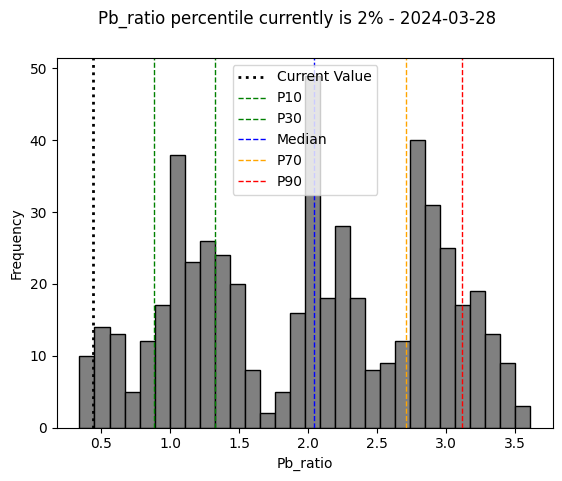

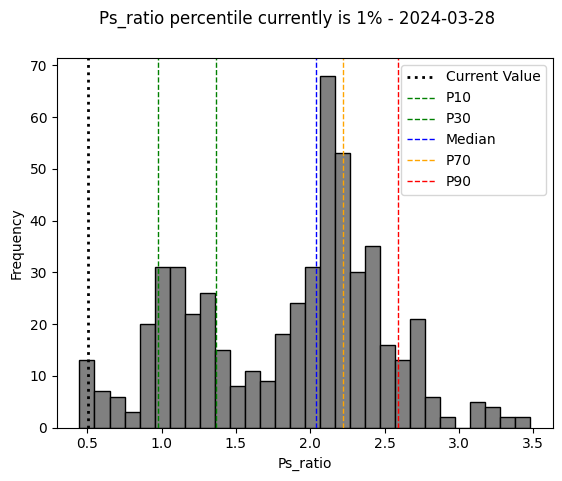

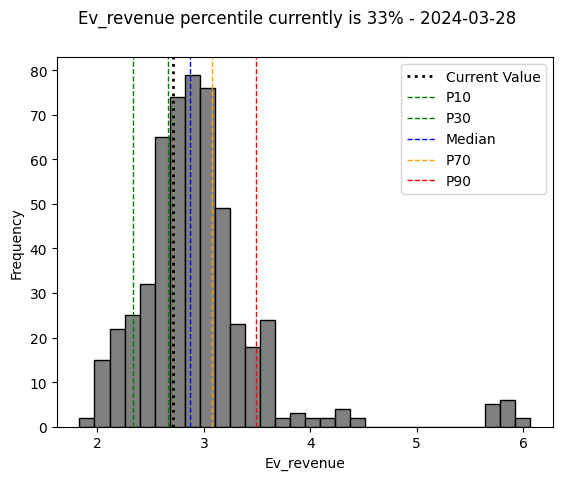

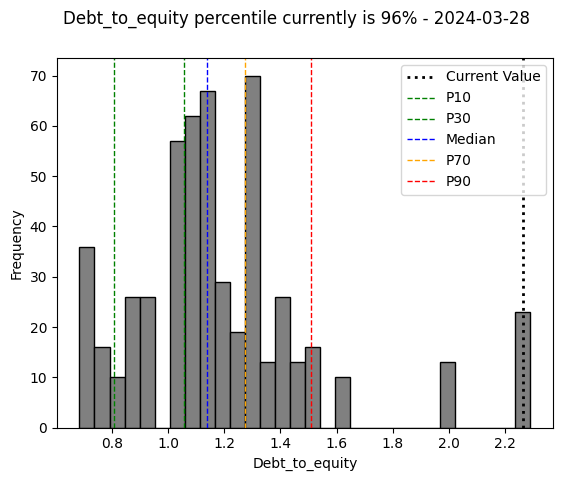

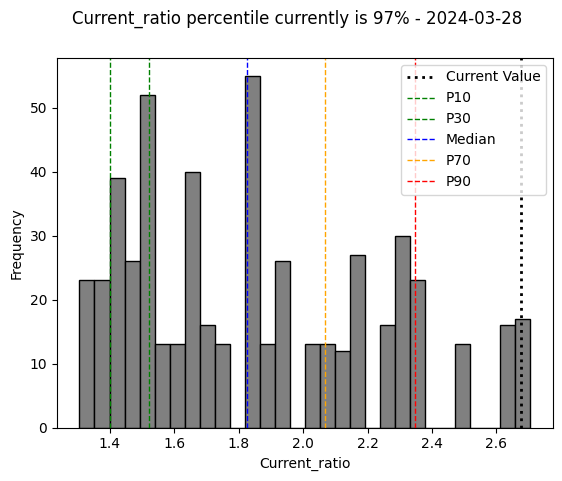

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.982505,0.289178,0.541854,0.388425,-0.030004,-0.560147,-0.087736
roe,0.982505,1.000000,0.219881,0.505705,0.416918,0.007725,-0.620271,-0.183543
pe_ratio,0.289178,0.219881,1.000000,0.299521,0.177938,0.025291,-0.080073,0.252948
pb_ratio,0.541854,0.505705,0.299521,1.000000,0.794776,0.225211,-0.613343,0.183679
ps_ratio,0.388425,0.416918,0.177938,0.794776,1.000000,0.644590,-0.720179,0.057306
ev_revenue,-0.030004,0.007725,0.025291,0.225211,0.644590,1.000000,-0.066232,0.036139
debt_to_equity,-0.560147,-0.620271,-0.080073,-0.613343,-0.720179,-0.066232,1.000000,0.117604
current_ratio,-0.087736,-0.183543,0.252948,0.183679,0.057306,0.036139,0.117604,1.000000


0 timestemos have been found!


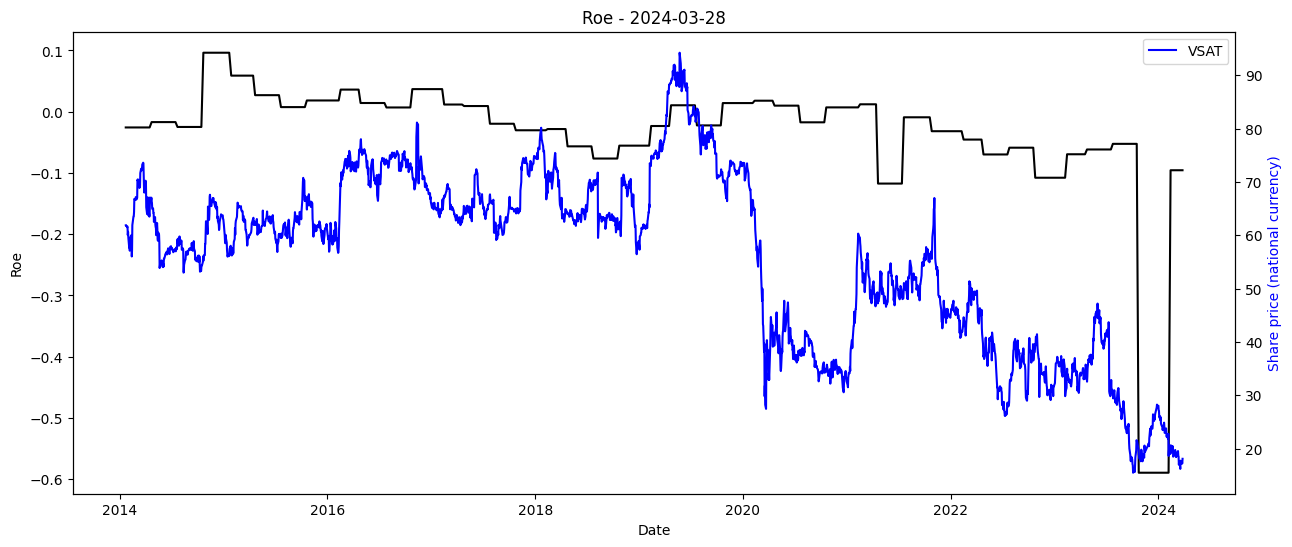

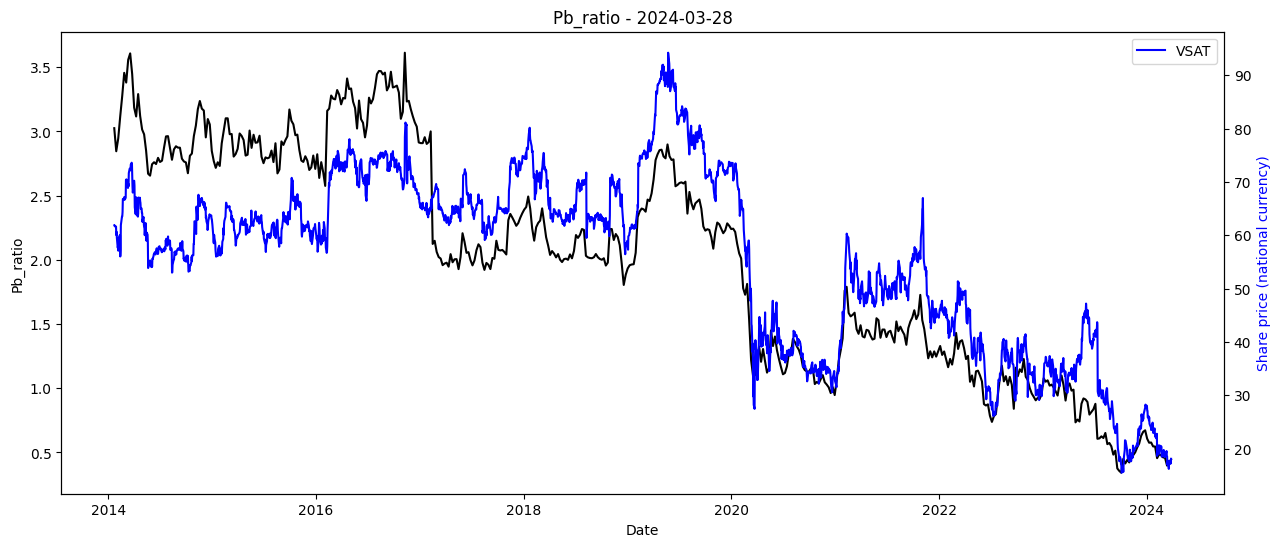

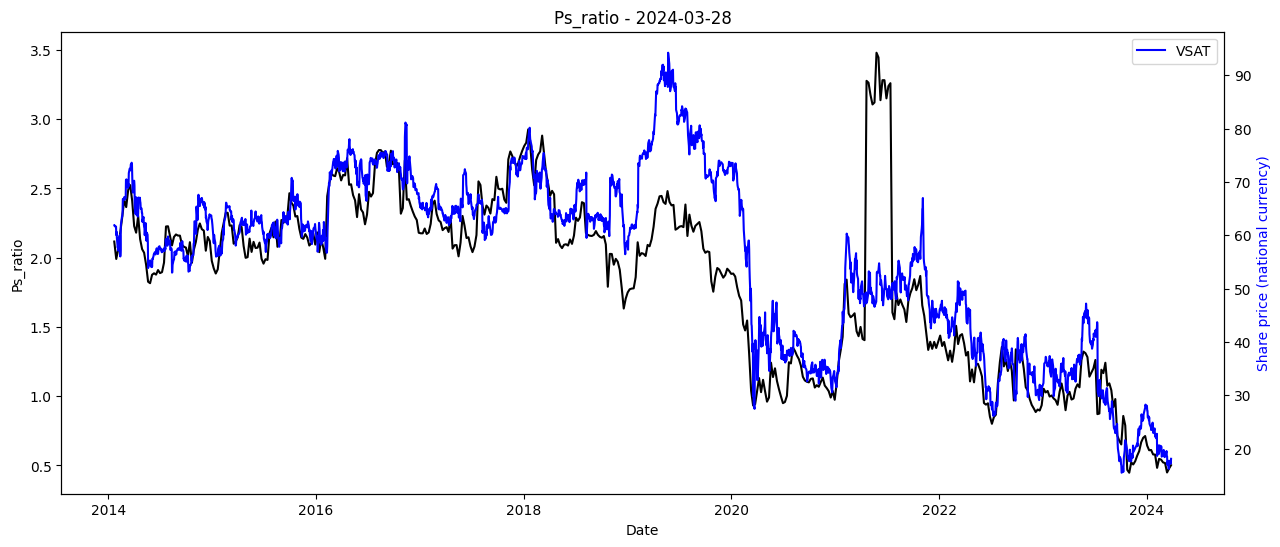

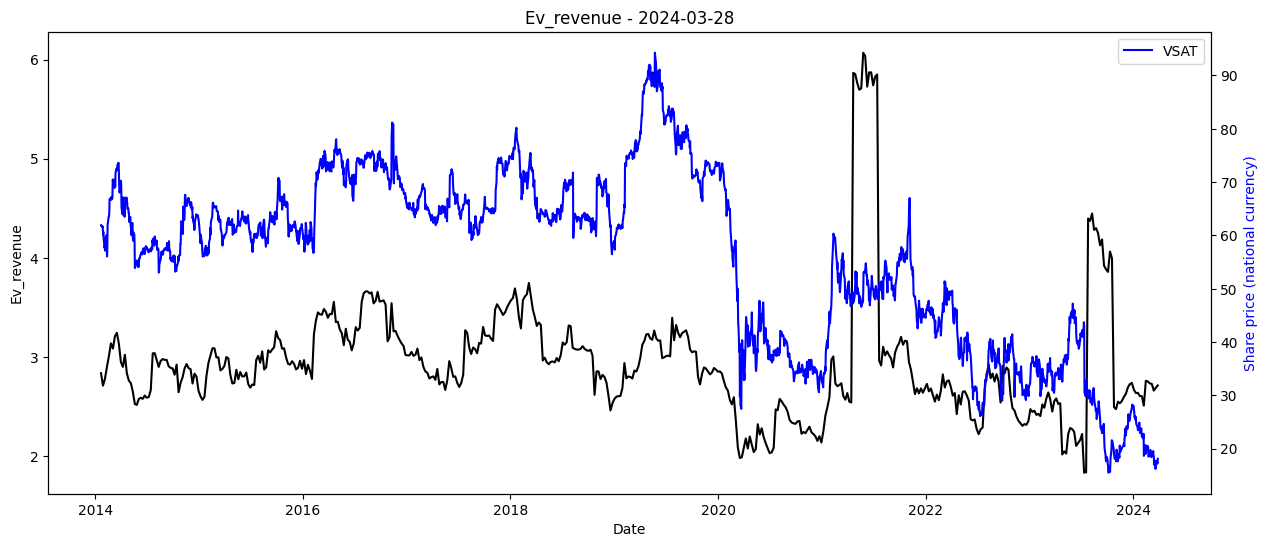

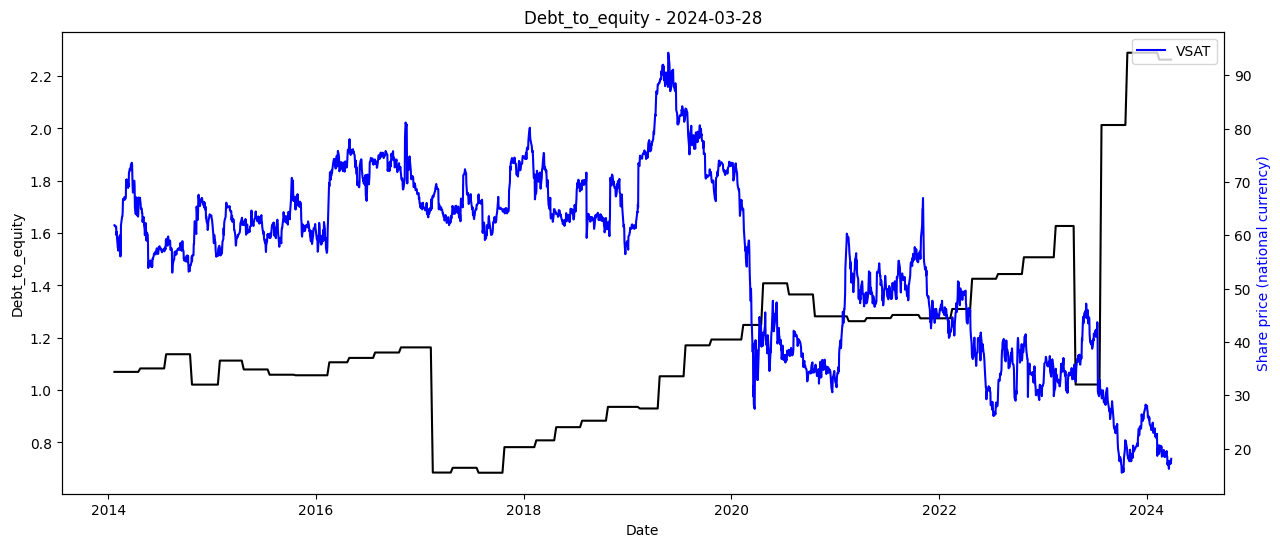

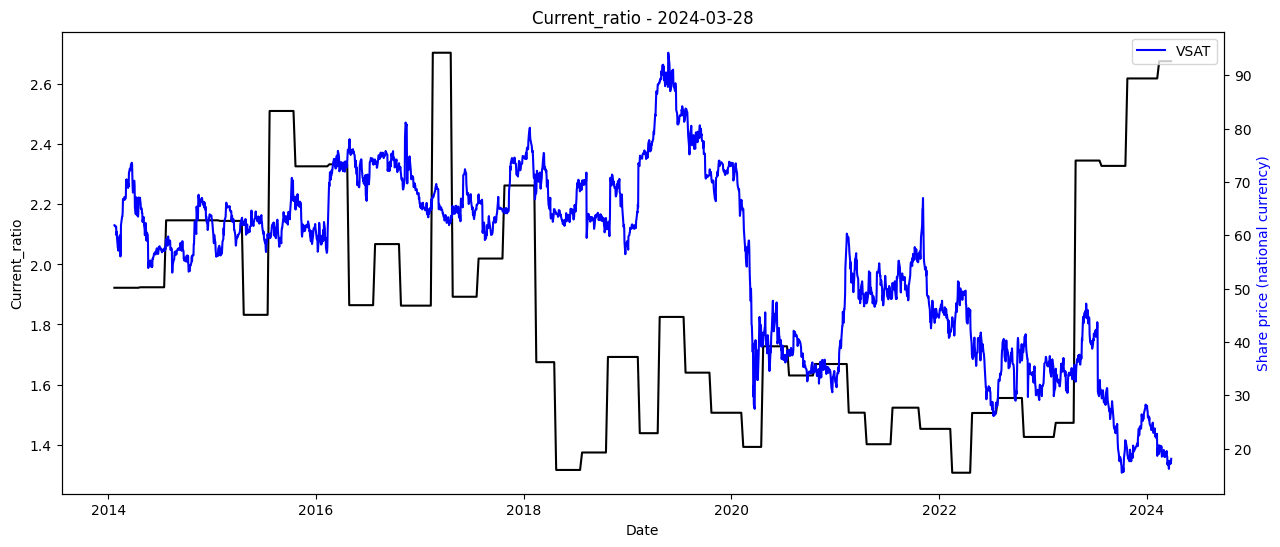

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )